In [70]:
# The code was removed by Watson Studio for sharing.

# Comparing the neighborhoods of Darmstadt and Karlsruhe - Data Science Study

This notebook contains the source code and visualizations of the data science study mentioned above. The study represents the 
final project of the online course 'Applied Data Science Capstone' on [coursera.org](https://www.coursera.org/learn/applied-data-science-capstone).
The main goal is to find out which neighborhoods of the two cities Karlsruhe and Darmstdt are similar to each other. Further information
can be found in the full report that can be found in the same repository. 

## 1. Getting information on the neighborhoods in the two cities

In [1]:
%matplotlib inline
# import libraries
import numpy as np
import requests # getting HTML content
import pandas as pd
from bs4 import BeautifulSoup # this is needed to scrape the tables from Wikipedia
import re # regular expressions
from geopy.geocoders import Nominatim # get local coordinates for areas

Scraping the data on the boroughs, neighborhoods and population density from the respective Wikipedia websites:

In [2]:
# Darmstadt
url_da='https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Darmstadt'
# Create a handle, page, to handle the contents of the website
page_da = requests.get(url_da).text
soup_da = BeautifulSoup(page_da,'lxml')
#print(soup_da.prettify)

In [3]:
# Karlsruhe
url_ka='https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Karlsruhe'
# Create a handle, page, to handle the contents of the website
page_ka = requests.get(url_ka).text
soup_ka = BeautifulSoup(page_ka,'lxml')
#print(soup_ka.prettify)

Find the table contents in the Wikipedia pages:

In [4]:
# Darmstadt
table_da = soup_da.find('table',{'class':'wikitable sortable'})
#table_da

In [5]:
# Karlsruhe
table_ka = soup_ka.find('table',{'class':'wikitable sortable'})
#table_ka

Extract the full content of the tables and save it as list:

In [6]:
# Darmstadt
table_rows = table_da.find_all('tr')
content_da = []
for i in table_rows:
    td = i.find_all('td')
    row = [i.text.strip() for i in td if i.text.strip()]
    if row:
        content_da.append(row)

#content_da

In [7]:
# Karlsruhe
for span_tag in table_ka.findAll('span'):
    span_tag.replace_with('')

table_rows = table_ka.find_all('tr')
content_ka = []
for i in table_rows:
    td = i.find_all('td')
    row = [i.text.strip() for i in td if i.text.strip()]
    if row:
        content_ka.append(row)

#content_ka

Get the names of the columns of both tables:

In [8]:
# Darmstadt
table_headers= table_da.find_all('th')
headers_da = []
for i in table_headers:
    name=i.text.replace("\n","")
    headers_da.append(name)
# Remove last column, as it is a picture column
headers_da=headers_da[:-1]
headers_da

['Nr.[3]',
 'Statistischer Bezirk/Stadtteil[3]',
 'Fläche in ha(Stand:\xa031.\xa0Dez.\xa02010)[3]',
 'Einwohner(Stand:\xa031.\xa0Dez.\xa02010)[3]',
 'Einwohner je ha(Stand:\xa031.\xa0Dez.\xa02010)[3]']

In [9]:
# Karlsruhe
table_headers= table_ka.find_all('th')
headers_ka = []
for i in table_headers:
    name=i.text.replace("\n","")
    headers_ka.append(name)
headers_ka

['Nr.',
 'StadtteilStadtviertel',
 'Fläche (ha)31. Dez. 2008',
 'Bevölkerung31. Dez. 2008',
 'Bevölkerungs-dichte']

Let’s make a pandas data frame out of it. Let's proceed by conducting all preparation steps for Darmstadt first. Then we will continue with the steps for Karlsruhe.

### 1.1 Making a data frame for Darmstadt

In [10]:
df_da_t1 = pd.DataFrame(content_da,columns=headers_da)
df_da_t1.head()

,Nr.[3],Statistischer Bezirk/Stadtteil[3],Fläche in ha(Stand: 31. Dez. 2010)[3],Einwohner(Stand: 31. Dez. 2010)[3],Einwohner je ha(Stand: 31. Dez. 2010)[3]
0,100,Darmstadt-Mitte,"233,0",17611,"75,6"
1,110,Stadtzentrum,"30,0",1419,"47,3"
2,120,Rheintor/Grafenstraße,"39,9",3565,"89,4"
3,130,Hochschulviertel,"41,5",571,"13,8"
4,140,Kapellplatzviertel,"49,7",5341,"107,5"


Clean the columns that are of no interest and translate the column headers:

In [11]:
df_da_t1.columns=['Identifier','Neighborhood','Area in ha','Inhabitants','Density Inh/ha']

Clean the summarizing rows that contain text in 'Identifier'. Furthermore, let's extract the respective boroughs' names, indicated by idenitfier with the number '*00' to an extra column:

In [12]:
df_da_t1.drop([28,46,47],inplace=True)

In [13]:
df_da_t1['Borough']='tbd'

Let's define a useful function that enables a clean depiction of the boroughs and their neighborhoods considering the specific format of the tables for both original Darmstadt and Karlsruhe data:

In [14]:
def groupToBoroughs(df,identifier):
    if(identifier=='DA'):
        for index, row in df.iterrows():
            if(re.search('.00',row.Identifier)):
                borough_name=row['Neighborhood']
                #print(borough_name)
            row['Borough']=borough_name
    elif(identifier=='KA'):
        for index, row in df.iterrows():
            if(re.search('^\d{2}$',row.Identifier)):
                borough_name=row['Neighborhood']
                #print(borough_name)
            row['Borough']=borough_name
    else:
        print("Unknown identifier: ",identifier)
        exit()
        
    #df.head()
    #Now clean the general rows which are identifiable now since borough and neighborhood names are identical
    df_clean=df.drop(df[df.Borough==df.Neighborhood].index)
    return df_clean    

Applying that function for Darmstadt:

In [15]:
df_da_t2=groupToBoroughs(df_da_t1,'DA')

In [16]:
df_da_t2.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
1,110,Stadtzentrum,"30,0",1419,"47,3",Darmstadt-Mitte
2,120,Rheintor/Grafenstraße,"39,9",3565,"89,4",Darmstadt-Mitte
3,130,Hochschulviertel,"41,5",571,"13,8",Darmstadt-Mitte
4,140,Kapellplatzviertel,"49,7",5341,"107,5",Darmstadt-Mitte
5,150,St. Ludwig mit Eichbergviertel,"72,0",6715,"93,3",Darmstadt-Mitte


Reorder the columns:

In [17]:
# Reorder columns
df_da_t3 = df_da_t2[['Identifier', 'Borough', 'Neighborhood', 'Inhabitants','Area in ha', 'Density Inh/ha']]

In [18]:
df_da_t3.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,110,Darmstadt-Mitte,Stadtzentrum,1419,"30,0","47,3"
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,"39,9","89,4"
3,130,Darmstadt-Mitte,Hochschulviertel,571,"41,5","13,8"
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,"49,7","107,5"
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,"72,0","93,3"


Adapt the german number sparator rules to the universal ones:

In [19]:
df_da_t3['Inhabitants']=pd.to_numeric(df_da_t3['Inhabitants'])
df_da_t3["Area in ha"] = df_da_t3["Area in ha"].str.replace(",",".")
df_da_t3["Area in ha"] = df_da_t3["Area in ha"].str.replace(" ","")
df_da_t3['Area in ha']=pd.to_numeric(df_da_t3['Area in ha'])
df_da_t3["Density Inh/ha"] = df_da_t3["Density Inh/ha"].str.replace(",",".")
df_da_t3.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4
3,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3


Now that we have the names and population densities of Darmstadt's boroughs and neighborhoods, let's get their geographical. coordinates. For this task, we write again a function that does this job for us (and is useable for the Karlsruhe data later as well).

In [20]:
# this is needed to insert a pause which is in turn needed to avoid an annoying timeout error in geolocator
from time import sleep

In [21]:
def addCoordinatesToDF(df):
    geolocator = Nominatim()
    df_new=df.copy(deep=True)
    df_new['Latitude']='tbd'
    df_new['Longitude']='tbd'
    
    for i in df_new.index:
        borough_ = df_new.get_value(i,'Borough')
        neigh_   = df_new.get_value(i,'Neighborhood')
        
        try:
            location = geolocator.geocode("%s %s"%(borough_,neigh_))
            print("%s %s: %f,%f"%(borough_,neigh_,location.latitude,location.longitude))
            df_new.set_value( i,'Latitude',location.latitude)
            df_new.set_value( i,'Longitude',location.longitude)
        except:
            #location = geolocator.geocode("%s"%(borough_))
            print("Attention - couldn't find combination %s/%s, need to manage it manually!" %(borough_,neigh_))
        sleep(1.5)
    return df_new

In [22]:
df_da=addCoordinatesToDF(df_da_t3)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Darmstadt-Mitte Stadtzentrum: 49.872754,8.651161


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Darmstadt-Mitte Rheintor/Grafenstraße: 49.871606,8.647955
Darmstadt-Mitte Hochschulviertel: 49.876262,8.656890
Darmstadt-Mitte Kapellplatzviertel: 49.870864,8.659611
Darmstadt-Mitte St. Ludwig mit Eichbergviertel: 49.865945,8.652891
Darmstadt-Nord Johannesviertel: 49.878497,8.646980
Darmstadt-Nord Martinsviertel-West: 49.881000,8.658658
Darmstadt-Nord Martinsviertel-Ost: 49.879970,8.663805
Darmstadt-Nord Waldkolonie: 49.880212,8.618938
Darmstadt-Nord Mornewegviertel: 49.873056,8.637765
Darmstadt-Nord Pallaswiesenviertel: 49.880700,8.640945
Darmstadt-Nord Am Ziegelbusch: 49.885033,8.663485
Darmstadt-Ost Am Oberfeld: 49.879560,8.674064
Darmstadt-Ost Mathildenhöhe: 49.876814,8.667162
Darmstadt-Ost Woogsviertel: 49.869939,8.668695
Darmstadt-Ost An den Lichtwiesen: 49.865614,8.674185
Darmstadt-Bessungen Paulusviertel: 49.862124,8.660440
Darmstadt-Bessungen Alt-Bessungen: 49.859369,8.651541
Darmstadt-Bessungen An der Ludwigshöhe: 49.843035,8.663026
Darmstadt-West Am Südbahnhof: 49.856078,8.6

Let's manage to get the coordinates of the non-found neighborhoods manually.

In [23]:
df_da

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3,49.8728,8.65116
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3,49.8659,8.65289
7,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


In [24]:
# Alt-Arheilgen, data from https://tools.wmflabs.org/geohack/geohack.php?params=49.91262_N_8.65797_E_dim:10000_region:DE-HE_type:city(4169)&pagename=Alt-Arheilgen&language=de
df_da.at[30,'Latitude']=49.91262
df_da.at[30,'Longitude']=8.65797
# I found that the coordinates from geoPy are wrong for the following neighborhoods. Here, let's correct:
# Heimstättensiedlung, data from https://tools.wmflabs.org/geohack/geohack.php?params=49.84912_N_8.62827_E_dim:10000_region:DE-HE_type:city(6994)&pagename=Heimstättensiedlung_(Darmstadt)&language=de
df_da.at[25,'Latitude']=49.84912
df_da.at[25,'Longitude']=8.62827
# Arheilgen-Ost, https://tools.wmflabs.org/geohack/geohack.php?params=49.9035_N_8.67_E_dim:10000_region:DE-HE_type:city(1638)&pagename=Arheilgen-Ost&language=de
df_da.at[33,'Latitude']=49.9035
df_da.at[33,'Longitude']=8.67
# Kranichstein-Süd, https://tools.wmflabs.org/geohack/geohack.php?params=49.89661_N_8.67728_E_dim:10000_region:DE-HE_type:city(7745)&pagename=Kranichstein-Süd&language=de
df_da.at[44,'Latitude']=49.89661
df_da.at[44,'Longitude']=8.67728
# Kranichstein-Nord, https://tools.wmflabs.org/geohack/geohack.php?params=49.901_N_8.6891_E_dim:10000_region:DE-HE_type:city(3291)&pagename=Kranichstein-Nord&language=de
df_da.at[45,'Latitude']=49.901
df_da.at[45,'Longitude']=8.6891
# Wixhausen Ost, https://tools.wmflabs.org/geohack/geohack.php?params=49.93166_N_8.65935_E_dim:10000_region:DE-HE_type:city(3537)&pagename=Wixhausen-Ost&language=de
df_da.at[42,'Latitude']=49.93166
df_da.at[42,'Longitude']=8.65935
# Wixhausen West, https://tools.wmflabs.org/geohack/geohack.php?params=49.93247_N_8.64146_E_dim:10000_region:DE-HE_type:city(2238)&pagename=Wixhausen-West&language=de
df_da.at[41,'Latitude']=49.93247
df_da.at[41,'Longitude']=8.64146

In [25]:
df_da

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3,49.8728,8.65116
2,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3,49.8659,8.65289
7,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


### 1.2 Making a data frame for Darmstadt

Now create a shiny pandas data frame for the data of Karlsruhe.

In [26]:
df_ka_t1 = pd.DataFrame(content_ka,columns=headers_ka)
df_ka_t1.head()

,Nr.,StadtteilStadtviertel,Fläche (ha)31. Dez. 2008,Bevölkerung31. Dez. 2008,Bevölkerungs-dichte
0,01,Innenstadt-Ost,"160,12",5.890,3.679
1,011,Nordöstl. Teil,"128,83",1.252,972
2,012,Südwestl. Teil,"31,28",4.638,14.827
3,02,Innenstadt-West,"240,32",8.769,3.649
4,021,Östlicher Teil,"80,33",1.814,2.258


Transform and reorganize the column to get the same format like in the Darmstadt table:

In [27]:
df_ka_t1.columns=['Identifier','Neighborhood','Area in ha','Inhabitants','Density Inh/ha']
df_ka_t1['Borough']='tbd'
df_ka_t2=df_ka_t1.drop([92,93,94])
df_ka_t2.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
0,01,Innenstadt-Ost,"160,12",5.890,3.679,tbd
1,011,Nordöstl. Teil,"128,83",1.252,972,tbd
2,012,Südwestl. Teil,"31,28",4.638,14.827,tbd
3,02,Innenstadt-West,"240,32",8.769,3.649,tbd
4,021,Östlicher Teil,"80,33",1.814,2.258,tbd


In [28]:
df_ka_t3=groupToBoroughs(df_ka_t2,'KA')
df_ka_t3.head()

,Identifier,Neighborhood,Area in ha,Inhabitants,Density Inh/ha,Borough
1,011,Nordöstl. Teil,"128,83",1.252,972,Innenstadt-Ost
2,012,Südwestl. Teil,"31,28",4.638,14.827,Innenstadt-Ost
4,021,Östlicher Teil,"80,33",1.814,2.258,Innenstadt-West
5,022,Westlicher Teil,"159,99",6.955,4.347,Innenstadt-West
7,031,Nördlicher Teil,"38,08",6.214,16.318,Südstadt


In [29]:
# Reorder columns
df_ka_t4 = df_ka_t3[['Identifier', 'Borough', 'Neighborhood', 'Inhabitants','Area in ha','Density Inh/ha']]

In [30]:
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1.252,"128,83",972
2,012,Innenstadt-Ost,Südwestl. Teil,4.638,"31,28",14.827
4,021,Innenstadt-West,Östlicher Teil,1.814,"80,33",2.258
5,022,Innenstadt-West,Westlicher Teil,6.955,"159,99",4.347
7,031,Südstadt,Nördlicher Teil,6.214,"38,08",16.318


In [31]:
df_ka_t4["Inhabitants"] = df_ka_t4["Inhabitants"].str.replace(".","")
df_ka_t4["Area in ha"] = df_ka_t4["Area in ha"].str.replace(".","")
df_ka_t4["Area in ha"] = df_ka_t4["Area in ha"].str.replace(",",".")
df_ka_t4["Density Inh/ha"] = df_ka_t4["Density Inh/ha"].str.replace(".","")
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,972
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,14827
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,2258
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,4347
7,031,Südstadt,Nördlicher Teil,6214,38.08,16318


In [32]:
df_ka_t4['Density Inh/ha']=pd.to_numeric(df_ka_t4['Density Inh/ha'])
# Now correct unit to get Inh/ha
df_ka_t4['Density Inh/ha']=df_ka_t4['Density Inh/ha']/100

In [33]:
df_ka_t4.head()

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,9.72
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,148.27
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,22.58
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,43.47
7,031,Südstadt,Nördlicher Teil,6214,38.08,163.18


Let's get the coordinates for the Karslruhe neighborhoods:

In [34]:
df_ka=addCoordinatesToDF(df_ka_t4)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Attention - couldn't find combination Innenstadt-Ost/Nordöstl. Teil, need to manage it manually!
Attention - couldn't find combination Innenstadt-Ost/Südwestl. Teil, need to manage it manually!
Innenstadt-West Östlicher Teil: 49.011818,8.402726


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Innenstadt-West Westlicher Teil: 49.014847,8.393182
Südstadt Nördlicher Teil: 49.003372,8.408212
Südstadt Südlicher Teil: 48.995544,8.413061
Südstadt Östlicher Teil: 49.002057,8.419140
Südweststadt Östlicher Teil: 48.998120,8.398865
Südweststadt Mittlerer Teil: 49.000002,8.390050
Südweststadt Beiertheimer Feld: 48.999181,8.378254
Weststadt Mittlerer Teil: 49.013467,8.378470
Weststadt Südlicher Teil: 49.005543,8.372510
Nordweststadt Alter Flugplatz: 49.028738,8.375457
Nordweststadt Binsenschlauch: 49.024591,8.368255
Nordweststadt Lange Richtstatt: 49.037066,8.367481
Nordweststadt Rennbuckel: 49.027149,8.359936
Oststadt Nördlicher Teil: 49.017898,8.431106
Oststadt Südlicher Teil: 49.004730,8.432043
Oststadt Westlicher Teil: 49.018880,8.419088
Mühlburg Alt-Mühlburg: 49.014282,8.362075
Mühlburg Weingärtensiedlung: 49.020287,8.357200
Mühlburg Rheinhafen: 49.018837,8.339402
Mühlburg Mühlburger Feld: 49.007261,8.364817
Daxlanden Alt-Daxlanden: 48.999195,8.310111
Daxlanden Neu-Daxlanden: 49.00

In [35]:
# Innenstadt-Ost/Nordöstl. Teil, determined using https://www.gpskoordinaten.de
df_ka.at[1,'Latitude']=49.018376
df_ka.at[1,'Longitude']=8.410939800000051

# Innenstadt-Ost/Südwestl. Teil, determined using https://www.gpskoordinaten.de
df_ka.at[2,'Latitude']=49.0094097 
df_ka.at[2,'Longitude']=8.40942259999997

# Grünwinkel/Alte Heidenstücker, determined using https://www.gpskoordinaten.de
df_ka.at[43,'Latitude']=48.98959
df_ka.at[43,'Longitude']=8.351609999999937

# Südweststadt/Mittlerer Teil, 
df_ka.at[12,'Latitude']=49.1816403
df_ka.at[12,'Longitude']=8.624362799999972

## 2. Getting the venue data for Darmstadt and Karlsruhe from Foursquare

Load further libraries:

In [36]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00   7.92 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  33.35 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.65 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  46.44 MB/s


Use geopy library to get the latitude and longitude values of Darmstadt and Karlsruhe. For this, let's write another function:

In [37]:
def plotFoliumMap(cityname,df,zoom=10):
    geolocator = Nominatim()
    location = geolocator.geocode(cityname)
    latitude = location.latitude
    longitude = location.longitude
    
    # create map of the city using latitude and longitude values
    map_city = folium.Map(location=[latitude, longitude], zoom_start=zoom, control_scale = True)
    
    # add markers to map
    for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
        label = '{}, {}'.format(neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)  
    
    return map_city

Now go for a map plot using Folium:

In [38]:
df_ka

,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,011,Innenstadt-Ost,Nordöstl. Teil,1252,128.83,9.72,49.0184,8.41094
2,012,Innenstadt-Ost,Südwestl. Teil,4638,31.28,148.27,49.0094,8.40942
4,021,Innenstadt-West,Östlicher Teil,1814,80.33,22.58,49.0118,8.40273
5,022,Innenstadt-West,Westlicher Teil,6955,159.99,43.47,49.0148,8.39318
7,031,Südstadt,Nördlicher Teil,6214,38.08,163.18,49.0034,8.40821
8,032,Südstadt,Südlicher Teil,7545,144.09,52.36,48.9955,8.41306
9,033,Südstadt,Östlicher Teil,1611,38.32,42.04,49.0021,8.41914
11,041,Südweststadt,Östlicher Teil,5604,104.94,53.40,48.9981,8.39887
12,042,Südweststadt,Mittlerer Teil,11943,68.99,173.11,49.1816,8.62436
13,043,Südweststadt,Beiertheimer Feld,1271,122.72,10.36,48.9992,8.37825


In [39]:
map_ka = plotFoliumMap('Karlsruhe', df_ka,12)
map_ka

In [40]:
map_da = plotFoliumMap('Darmstadt', df_da,12)
map_da

Now let's get the information about the venues of each neighborhood of the two cities from foursquare:

In [41]:
# The code was removed by Watson Studio for sharing.

Add the information about the respective city: 

In [42]:
df_ka.insert(0, 'City', 'KA')
df_da.insert(0, 'City', 'DA')
df_da

,City,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,DA,110,Darmstadt-Mitte,Stadtzentrum,1419,30.0,47.3,49.8728,8.65116
2,DA,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,DA,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,DA,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,DA,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72.0,93.3,49.8659,8.65289
7,DA,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,DA,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,DA,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,DA,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,DA,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


Let's write another function that capsulates all calls to Foursquare for each of the neighborhoods of the two cities:

In [43]:
##### DEBUGGING

#latTEST=49.93247
#lngTEST=8.64146
#radius=500
#LIMIT=60

#url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&intent=browse'.format(
#            CLIENT_ID, 
#            CLIENT_SECRET, 
#            VERSION, 
#            lat, 
#            lng, 
#            radius, 
#            LIMIT)
#results = requests.get(url).json()

In [44]:
##### DEBUGGING
#resT=results["response"]["venues"]
#venT = []
#for v in resT:
#    if(len(v["categories"])>0):
#        venT.append((v["name"],
#              v["location"]["lat"],
#              v["location"]["lng"],
#              v["categories"][0]["name"]))

***Attention***: As Foursquare seems to return not strictly venues inside the given radius, but sometimes also venues from outside,
we use the following function to make a hard cut of these unwanted venues.

In [45]:
from geopy.distance import great_circle

In [46]:
def PointIsInCircle(lat_orig,lng_orig,lat_venue,lng_venue,radius):
    v_coord_=(lat_venue,lng_venue)
    main_coord_=(lat_orig,lng_orig)
    distance=great_circle(main_coord_, v_coord_).m
    if(distance<radius):
        return True
    else:
        return False

In [47]:
def getNearbyVenues(city, borough, neigh, inhabitants, latitudes, longitudes, radius):
    
    venues_list=[]
    for city, bor, name, inh, lat, lng in zip(city,borough, neigh, inhabitants, latitudes, longitudes):
        print(city,bor,name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?intent=browse&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        res_temp = requests.get(url).json()["response"]["venues"]
        
        # return only relevant information for each nearby venue
        for v in res_temp:
            if(len(v["categories"])>0) and PointIsInCircle(lat,lng,v["location"]["lat"],v["location"]["lng"],radius):
                venues_list.append((
                    city,
                    bor,
                    name, 
                    inh,
                    lat, 
                    lng, 
                    v["name"],
                    v["location"]["lat"],
                    v["location"]["lng"], 
                    v["categories"][0]["name"]))

    nearby_venues = pd.DataFrame.from_records(venues_list)
    nearby_venues.columns = ['City',
                  'Borough',
                  'Neighborhood', 
                  'Density Inh/ha',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Merge the two data frames of the cities:

In [48]:
df_both = pd.concat([df_da,df_ka])
df_both

,City,Identifier,Borough,Neighborhood,Inhabitants,Area in ha,Density Inh/ha,Latitude,Longitude
1,DA,110,Darmstadt-Mitte,Stadtzentrum,1419,30,47.3,49.8728,8.65116
2,DA,120,Darmstadt-Mitte,Rheintor/Grafenstraße,3565,39.9,89.4,49.8716,8.64796
3,DA,130,Darmstadt-Mitte,Hochschulviertel,571,41.5,13.8,49.8763,8.65689
4,DA,140,Darmstadt-Mitte,Kapellplatzviertel,5341,49.7,107.5,49.8709,8.65961
5,DA,150,Darmstadt-Mitte,St. Ludwig mit Eichbergviertel,6715,72,93.3,49.8659,8.65289
7,DA,210,Darmstadt-Nord,Johannesviertel,4839,38.3,126.4,49.8785,8.64698
8,DA,220,Darmstadt-Nord,Martinsviertel-West,5576,37.9,147.0,49.881,8.65866
9,DA,230,Darmstadt-Nord,Martinsviertel-Ost,5365,29.1,184.6,49.88,8.66381
10,DA,240,Darmstadt-Nord,Waldkolonie,4291,448.5,9.6,49.8802,8.61894
11,DA,250,Darmstadt-Nord,Mornewegviertel,650,52.4,12.4,49.8731,8.63776


Now get the venues of all neighbourhoods in the two cities:

In [49]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 800 # define radius in m

In [50]:
venues = getNearbyVenues(city=df_both['City'],
                            borough=df_both['Borough'],
                            neigh=df_both['Neighborhood'],
                            inhabitants=df_both['Density Inh/ha'],
                            latitudes=df_both['Latitude'],
                            longitudes=df_both['Longitude'],
                            radius=radius
                           )

DA Darmstadt-Mitte Stadtzentrum
DA Darmstadt-Mitte Rheintor/Grafenstraße
DA Darmstadt-Mitte Hochschulviertel
DA Darmstadt-Mitte Kapellplatzviertel
DA Darmstadt-Mitte St. Ludwig mit Eichbergviertel
DA Darmstadt-Nord Johannesviertel
DA Darmstadt-Nord Martinsviertel-West
DA Darmstadt-Nord Martinsviertel-Ost
DA Darmstadt-Nord Waldkolonie
DA Darmstadt-Nord Mornewegviertel
DA Darmstadt-Nord Pallaswiesenviertel
DA Darmstadt-Nord Am Ziegelbusch
DA Darmstadt-Ost Am Oberfeld
DA Darmstadt-Ost Mathildenhöhe
DA Darmstadt-Ost Woogsviertel
DA Darmstadt-Ost An den Lichtwiesen
DA Darmstadt-Bessungen Paulusviertel
DA Darmstadt-Bessungen Alt-Bessungen
DA Darmstadt-Bessungen An der Ludwigshöhe
DA Darmstadt-West Am Südbahnhof
DA Darmstadt-West Heimstättensiedlung
DA Darmstadt-West Verlegerviertel
DA Darmstadt-West Am Kavalleriesand
DA Darmstadt-Arheilgen Alt-Arheilgen
DA Darmstadt-Arheilgen Arheilgen-Süd
DA Darmstadt-Arheilgen Arheilgen-West
DA Darmstadt-Arheilgen Arheilgen-Ost
DA Darmstadt-Eberstadt Alt-E

Let's have a quick look on the resulting data frame

In [51]:
venues.head()

,City,Borough,Neighborhood,Density Inh/ha,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Luisenplatz,49.872802,8.651197,Plaza
1,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,H Luisenplatz,49.872812,8.650930,Tram Station
2,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Starbucks,49.872698,8.650989,Coffee Shop
3,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Back-Factory,49.872350,8.651028,Bakery
4,DA,Darmstadt-Mitte,Stadtzentrum,47.3,49.872754,8.651161,Postbank Finanzcenter,49.873066,8.650269,Bank


How many venues do we have in each neighborhood?

In [52]:
venues.groupby(['City','Borough','Neighborhood'])['Venue'].count()

City  Borough                 Neighborhood                  
DA    Darmstadt-Arheilgen     Alt-Arheilgen                      56
                              Arheilgen-Ost                      28
                              Arheilgen-Süd                      69
                              Arheilgen-West                     36
      Darmstadt-Bessungen     Alt-Bessungen                     125
                              An der Ludwigshöhe                  6
                              Paulusviertel                     112
      Darmstadt-Eberstadt     Alt-Eberstadt                     104
                              Am Frankenstein                    55
                              Am Lämmchesberg                    62
                              Kirchtannensiedlung                28
                              Villenkolonie                      19
      Darmstadt-Kranichstein  Kranichstein-Nord                  29
                              Kranichstein-Süd         

In [53]:
print('There are {} unique categories in the two cities.'.format(len(venues['Venue Category'].unique())))

There are 485 unique categories in the two cities.


## 3. Data Manufacturing

First of all, we need to transform the data of the population denstiy to [0,1]. 
This is required, since all venue-related features will be in this range and since 
cluster models are very sensitive to the quantity ranges of the data, this step is 
required.

In [54]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
density_scaled = scaler.fit_transform(venues[['Density Inh/ha']])
density_scaled

array([[ 0.25339859],
       [ 0.25339859],
       [ 0.25339859],
       ..., 
       [ 0.16617727],
       [ 0.16617727],
       [ 0.16617727]])

Let's continue with a one-hot-encoding step for all venue categories

In [55]:
# one hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add region info columns back to dataframe
venues_onehot.insert(0, 'CityName', venues['City'])
venues_onehot.insert(1, 'BoroughName', venues['Borough'])
venues_onehot.insert(2, 'NeighborhoodName', venues['Neighborhood'])
venues_onehot.insert(3, 'Scaled Pop. Density', density_scaled)
venues_onehot.insert(4, 'Neighborhood Latitude', venues['Neighborhood Latitude'])
venues_onehot.insert(5, 'Neighborhood Longitude', venues['Neighborhood Longitude'])

venues_onehot.head()

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density,Neighborhood Latitude,Neighborhood Longitude,ATM,Accessories Store,Adult Boutique,Adult Education Center,...,Water Park,Well,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,49.872754,8.651161,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,49.872754,8.651161,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,49.872754,8.651161,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,49.872754,8.651161,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DA,Darmstadt-Mitte,Stadtzentrum,0.253399,49.872754,8.651161,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by city/borough/neighborhood/Scaled Pop. density by taking the mean of the frequency of occurrence of each category

In [56]:
venues_grouped = venues_onehot.groupby(['CityName','BoroughName','NeighborhoodName','Scaled Pop. Density','Neighborhood Latitude','Neighborhood Longitude']).mean().reset_index()

Check the resulting data frame:

In [57]:
venues_grouped.head()

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density,Neighborhood Latitude,Neighborhood Longitude,ATM,Accessories Store,Adult Boutique,Adult Education Center,...,Water Park,Well,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,DA,Darmstadt-Arheilgen,Alt-Arheilgen,0.107123,49.912620,8.657970,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.0
1,DA,Darmstadt-Arheilgen,Arheilgen-Ost,0.030451,49.903500,8.670000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,DA,Darmstadt-Arheilgen,Arheilgen-Süd,0.237085,49.873702,8.640891,0.0,0.0,0.0,0.014493,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,DA,Darmstadt-Arheilgen,Arheilgen-West,0.065253,49.913737,8.645475,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,DA,Darmstadt-Bessungen,Alt-Bessungen,0.470364,49.859369,8.651541,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.008000,0.0,0.0,0.0,0.0,0.0


Let's create a data frame to show the 10 most common venues:

In [58]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[6:] # Do not consider names of city, borough, neighborhood, not pop. density...
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [59]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['CityName','BoroughName','NeighborhoodName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['CityName'] = venues_grouped['CityName']
neighborhoods_venues_sorted['BoroughName'] = venues_grouped['BoroughName']
neighborhoods_venues_sorted['NeighborhoodName'] = venues_grouped['NeighborhoodName']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 3:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,CityName,BoroughName,NeighborhoodName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,DA,Darmstadt-Arheilgen,Alt-Arheilgen,Tram Station,Italian Restaurant,Dentist's Office,Ice Cream Shop,Hotel,Cosmetics Shop,Salon / Barbershop,Bank,Bakery,Pizza Place
1,DA,Darmstadt-Arheilgen,Arheilgen-Ost,Government Building,Restaurant,Middle School,Lake,Bank,Baseball Field,Tech Startup,Tattoo Parlor,Steakhouse,Building
2,DA,Darmstadt-Arheilgen,Arheilgen-Süd,Hotel,Courthouse,Salon / Barbershop,Electronics Store,Asian Restaurant,Hookah Bar,Public Art,Grocery Store,Radio Station,Building
3,DA,Darmstadt-Arheilgen,Arheilgen-West,Office,Hotel,Playground,Asian Restaurant,Hardware Store,Electronics Store,Light Rail Station,Tram Station,Recycling Facility,Dentist's Office
4,DA,Darmstadt-Bessungen,Alt-Bessungen,Office,Tram Station,German Restaurant,Bakery,Italian Restaurant,French Restaurant,Café,Pizza Place,Library,Park
5,DA,Darmstadt-Bessungen,An der Ludwigshöhe,Other Great Outdoors,Mountain,Scenic Lookout,German Restaurant,School,Zoo Exhibit,EV Charging Station,Distribution Center,Dive Bar,Doctor's Office
6,DA,Darmstadt-Bessungen,Paulusviertel,Doctor's Office,Park,Italian Restaurant,Tram Station,Office,Church,Residential Building (Apartment / Condo),Bakery,Food & Drink Shop,Fraternity House
7,DA,Darmstadt-Eberstadt,Alt-Eberstadt,Doctor's Office,Italian Restaurant,Bakery,Bank,Pharmacy,Bus Stop,Pub,Pizza Place,Medical Center,Playground
8,DA,Darmstadt-Eberstadt,Am Frankenstein,Playground,Bus Stop,Bakery,Supermarket,Tram Station,Pharmacy,Hospital,Pub,Bank,Residential Building (Apartment / Condo)
9,DA,Darmstadt-Eberstadt,Am Lämmchesberg,Office,Italian Restaurant,Doctor's Office,Gas Station,Ice Cream Shop,Tech Startup,Building,Ethiopian Restaurant,Neighborhood,Daycare


## 4. Cluster Models

Now let's create the cluster models. Let's start with a k-Means model to get a first idea about which and how many types of groups we will get.

### 4.1 K-Means Model

Import k-means from clustering stage

In [60]:
from sklearn.cluster import KMeans

Extract the features from the general data frame:

In [61]:
venues_cluster=venues_grouped.copy()

venues_cluster.drop(columns=['CityName','BoroughName','NeighborhoodName','Neighborhood Latitude','Neighborhood Longitude'], inplace=True)
venues_cluster.head()

,Scaled Pop. Density,ATM,Accessories Store,Adult Boutique,Adult Education Center,Advertising Agency,African Restaurant,Alternative Healer,American Restaurant,Animal Shelter,...,Water Park,Well,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0.107123,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,0.0
1,0.030451,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.237085,0.0,0.0,0.0,0.014493,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.065253,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.470364,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.008000,0.0,0.0,0.0,0.0,0.0


Check the optimal value for k in k-Means clustering via the elbow method:

In [62]:
sum_of_squared_distances = []
K = range(1,10)
for k in K:
    print('Modeling k-Means with k=%i'%(k))
    km = KMeans(n_clusters=k, random_state=0).fit(venues_cluster)
    sum_of_squared_distances.append(km.inertia_)

Modeling k-Means with k=1
Modeling k-Means with k=2
Modeling k-Means with k=3
Modeling k-Means with k=4
Modeling k-Means with k=5
Modeling k-Means with k=6
Modeling k-Means with k=7
Modeling k-Means with k=8
Modeling k-Means with k=9


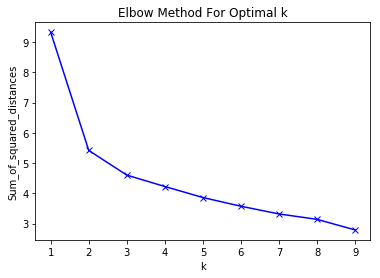

In [63]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We see the elbow is placed at around 3, which suggests that we can distinguish all quarters in 3 different groups. SInce we are interested, however, in finding out which neighborhoods are very similar to each other, we do not follow k-Means further, but we now apply hierarchical clustering.

### 4.2 Hierarchical clustering

For the hierarchical clustering process, we want to create a dendrogram, as it is a powerful tool to determine which neighbourhoods are especially similar to each other:

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Create the cluster model:

In [65]:
Z = linkage(venues_cluster, 'ward')

Now create the dendrogram:

In [66]:
def getCityIndex(name):
    if(name=='KA'):
        return 0
    elif(name=='DA'):
        return 1
    else:
        print('City name %s not found!' %(name))
        exit()

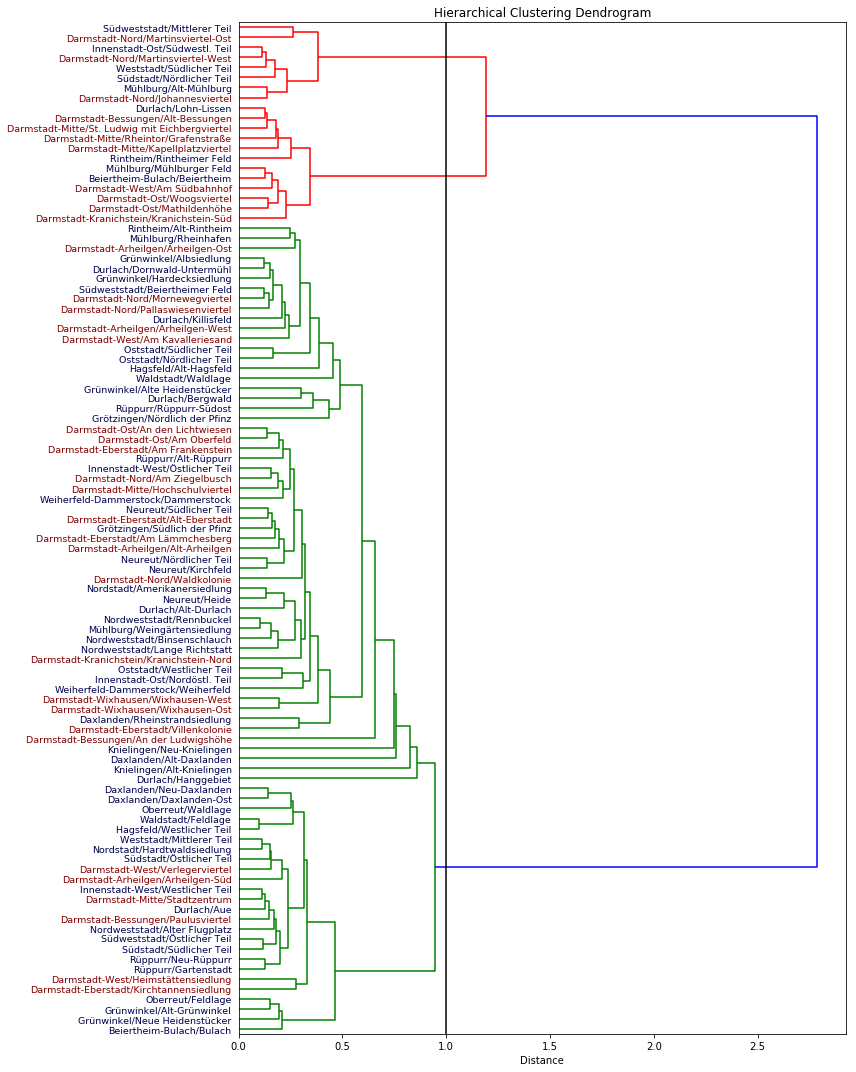

In [67]:
# calculate full dendrogram
df_temp=venues_grouped.copy()
fig=plt.figure(figsize=(12, 15))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')

label_list=df_temp['BoroughName']+'/'+df_temp['NeighborhoodName']
label_list=label_list.tolist()

dendrogram(
    Z,
    orientation='right',
    leaf_rotation=0,  # rotates the x axis labels
    leaf_font_size=9.5,  # font size for the x axis labels
    labels=label_list
)

# Create a color palette with 2 colors (for KA and DA)
my_palette = plt.cm.get_cmap("seismic", 2)

ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
for i in range(len(xlbls)):
    city_series=df_temp[df_temp['BoroughName']+'/'+df_temp['NeighborhoodName']==xlbls[i].get_text()].CityName # get the name of the city for the current neighborhood
    city_name=city_series.values[0]
    #print(city_series)
    val=getCityIndex(city_name)
    #print(city_name,val)
    xlbls[i].set_color(my_palette(val))

# cutoff line
d_max=1.0
plt.axvline(x=d_max, c='k', label='cutoff line')
fig.tight_layout()
plt.savefig("dendrogram.pdf",format='pdf')
plt.show()


In [71]:
file_data=open("dendrogram.pdf", 'rb')
project.save_data(data=file_data.read(),file_name='dendrogram.pdf',overwrite=True)
file_data.close()

Based on what we see, it seems reasonable to select only 2 clusters (corresponding to what we saw in the elbow method). However, let's put the cutoff line to distance=1.0 to get 3 clusters, which is also a valid choice.

Now let's get the cluster indices for this choice:

In [72]:
clusters = fcluster(Z, d_max, criterion='distance')
clusters

array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 3, 3, 3,
       1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 3], dtype=int32)

Add the information of the cluster number to the main data frame:

In [73]:
venues_final=venues_grouped.copy()
venues_final.insert(6,'Cluster',clusters)
venues_final

,CityName,BoroughName,NeighborhoodName,Scaled Pop. Density,Neighborhood Latitude,Neighborhood Longitude,Cluster,ATM,Accessories Store,Adult Boutique,...,Water Park,Well,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,DA,Darmstadt-Arheilgen,Alt-Arheilgen,0.107123,49.912620,8.657970,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000
1,DA,Darmstadt-Arheilgen,Arheilgen-Ost,0.030451,49.903500,8.670000,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,DA,Darmstadt-Arheilgen,Arheilgen-Süd,0.237085,49.873702,8.640891,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,DA,Darmstadt-Arheilgen,Arheilgen-West,0.065253,49.913737,8.645475,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,DA,Darmstadt-Bessungen,Alt-Bessungen,0.470364,49.859369,8.651541,2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000
5,DA,Darmstadt-Bessungen,An der Ludwigshöhe,0.019032,49.843035,8.663026,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,DA,Darmstadt-Bessungen,Paulusviertel,0.207722,49.862124,8.660440,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.008929,0.000000,0.000000,0.000000,0.000000,0.000000
7,DA,Darmstadt-Eberstadt,Alt-Eberstadt,0.108755,49.817821,8.644193,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,DA,Darmstadt-Eberstadt,Am Frankenstein,0.038608,49.811362,8.650984,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,DA,Darmstadt-Eberstadt,Am Lämmchesberg,0.058728,49.818430,8.633166,1,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [74]:
print(venues_cluster.columns.tolist())

['Scaled Pop. Density', 'ATM', 'Accessories Store', 'Adult Boutique', 'Adult Education Center', 'Advertising Agency', 'African Restaurant', 'Alternative Healer', 'American Restaurant', 'Animal Shelter', 'Antique Shop', 'Arcade', 'Art Gallery', 'Art Museum', 'Art Studio', 'Arts & Crafts Store', 'Arts & Entertainment', 'Asian Restaurant', 'Assisted Living', 'Athletics & Sports', 'Auditorium', 'Auto Dealership', 'Auto Garage', 'Auto Workshop', 'Automotive Shop', 'BBQ Joint', 'Baby Store', 'Badminton Court', 'Bagel Shop', 'Bakery', 'Ballroom', 'Bank', 'Bar', 'Baseball Field', 'Baseball Stadium', 'Basketball Court', 'Beach', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Betting Shop', 'Big Box Store', 'Bike Rental / Bike Share', 'Bike Shop', 'Bistro', 'Board Shop', 'Boarding House', 'Boat Rental', 'Boat or Ferry', 'Bookstore', 'Botanical Garden', 'Boutique', 'Bowling Alley', 'Bowling Green', 'Breakfast Spot', 'Brewery', 'Bridal Shop', 'Bridge', 'Buffet', 'Building', 'Burger J

## 5. Analysis and Interpretation

A complete analysis of the results are given in the full report that is also part of the current repo. Here, we only create the
visualisations required in the report.

#### Visualize the clusters

In [75]:
# set color scheme for the clusters
kclusters=3
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [76]:
def plotFoliumMapClusters(cityname,df,zoom=10):
    geolocator = Nominatim()
    location = geolocator.geocode(cityname)
    latitude = location.latitude
    longitude = location.longitude
    
    # create map of the city using latitude and longitude values
    map_city = folium.Map(location=[latitude, longitude], zoom_start=zoom, control_scale = True)
    
    # add markers to map
    for lat, lng, borough, neighborhood, cluster in zip(df['Neighborhood Latitude'], df['Neighborhood Longitude'], df['BoroughName'], df['NeighborhoodName'], df['Cluster']):
        label = '{}, {}, Cluster {}'.format(neighborhood, borough, cluster)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_city)  
    
    return map_city

In [77]:
map_cl_da = plotFoliumMapClusters('Darmstadt',venues_final,11.5)
map_cl_da.save("map_cl_da.html")
map_cl_da

In [78]:
map_cl_ka = plotFoliumMapClusters('Karlsruhe',venues_final,12)
map_cl_ka.save("map_cl_ka.html")
map_cl_ka

In [97]:
file_data=open("map_cl_da.html", 'rb')
project.save_data(data=file_data.read(),file_name='map_cl_da.html',overwrite=True)
file_data.close()

In [96]:
file_data=open("map_cl_ka.html", 'rb')
project.save_data(data=file_data.read(),file_name='map_cl_ka.html',overwrite=True)
file_data.close()

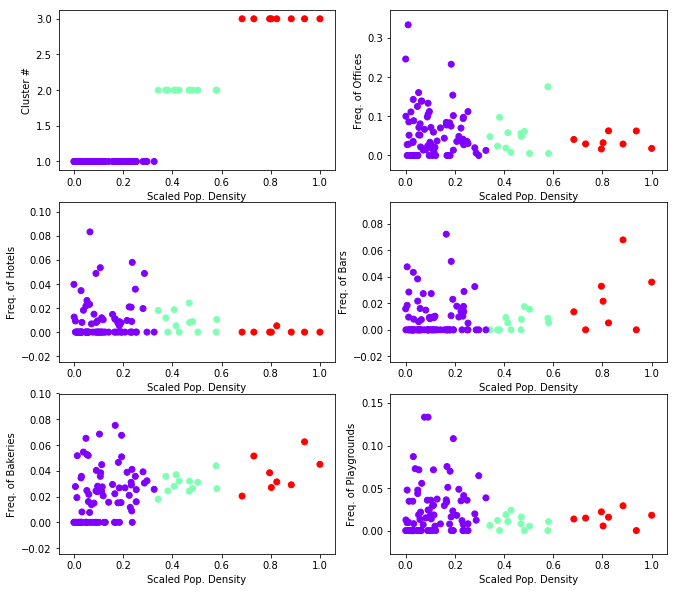

In [94]:
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(10.9,10))

ax=axes[0,0]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Cluster'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Cluster #')

ax=axes[0,1]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Office'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Freq. of Offices')

ax=axes[1,0]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Hotel'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Freq. of Hotels')

ax=axes[1,1]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Bar'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Freq. of Bars')

ax=axes[2,0]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Bakery'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Freq. of Bakeries')

ax=axes[2,1]
ax.scatter(venues_final['Scaled Pop. Density'], venues_final['Playground'], c=venues_final['Cluster'], cmap=colors.ListedColormap(rainbow))
ax.set_xlabel('Scaled Pop. Density')
ax.set_ylabel('Freq. of Playgrounds')

fig.savefig('scatter_plot_da_ka.pdf')

In [95]:
file_data=open("scatter_plot_da_ka.pdf", 'rb')
project.save_data(data=file_data.read(),file_name='scatter_plot_da_ka.pdf',overwrite=True)
file_data.close()

Interpretation:  

***Cluster 1***: Mixed areas, where people work (offices) and live. Crowded in the morning and evening (Bakeries and Bars). The large ratio of playgrounds suggests that a lot of families live here. This corresponds to the rather low population densitty, since families often live in their own houses. However, the low population density is also explainable by the multiple offices.

***Cluster 2***: 
Housing areas preferably for people without children (see Playgrounds). The high population ratio further suggests many multi-storey buildings (the frequency of offices is also reduced a bit, but they are still significant favoring the interpretation of multi-storey buildings). This might be counter-intuitive regarding the smaller frequency of bars, however, as we see from the maps, these neighborhoods are mostly very central in the cities and hence, people can reach the bars in other respective neighborhoods downtown easily.

***Cluster 3***:
Again areas for people without children and the presence of multi-storey buildings. The low frequency of offices and hotels, but in turn the high frequency of bars suggests that these neighborhoods might be preferred by students and rather young people.

#### The most similar neighborhoods among the two cities...

... seem to be Martinsviertel-West (Darmstadt) and Innenstadt-Ost/Südwestlicher Teil (Karlsruhe) following the dendrogram.

In [80]:
from folium.features import DivIcon
import os
import time
!conda install -c conda-forge selenium
from selenium import webdriver

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    selenium: 3.14.1-py35h470a237_0 conda-forge

selenium-3.14. 100% |################################| Time: 0:00:00  61.31 MB/s


In [81]:
def return_most_common_venues_and_values(neighborhoodName,df,num_top_venues):
    df_temp=df[df['NeighborhoodName']==neighborhoodName].iloc[0, :]
    row_categories = df_temp.iloc[6:] # Do not consider names of city, borough, neighborhood and also not pop. density
    row_categories_sorted = row_categories.sort_values(ascending=False)
    #print(row_categories_sorted[0:num_top_venues])
    t1=row_categories_sorted.reset_index()
    t1.columns=['Venue','Freq']
    return t1[0:num_top_venues]

In [135]:
def printTwoNeighborhoodsWithBars(name_a, name_b, df, filename, N_bars=10):
    
    t_frame_a=return_most_common_venues_and_values(name_a,df,N_bars)
    intIndex_a=df[df['NeighborhoodName']==name_a].index.values[0]
    t_frame_b=return_most_common_venues_and_values(name_b,df,N_bars)
    intIndex_b=df[df['NeighborhoodName']==name_b].index.values[0]

    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))

    borough_a = venues_grouped.loc[intIndex_a,'BoroughName']
    city_a = venues_grouped.loc[intIndex_a,'CityName']
    ax1 = t_frame_a.plot(x='Venue',y='Freq',kind='bar',legend=False, title="%s/%s/%s"%(city_a,borough_a,name_a),ax=axes[0])
    ax1.set_xlabel('Venue Categories')
    ax1.set_ylabel('Frequency, -')
    ax1.text(3, ax1.get_ylim()[1]*0.9, r'Scaled pop. density: %f'%(venues_grouped.loc[intIndex_a,'Scaled Pop. Density']))
    #ax1.set_ylim(0,1.0)

    borough_b = venues_grouped.loc[intIndex_b,'BoroughName']
    city_b = venues_grouped.loc[intIndex_b,'CityName']
    ax2=t_frame_b.plot(x='Venue',y='Freq',kind='bar',legend=False, title="%s/%s/%s"%(city_b,borough_b,name_b),ax=axes[1])
    ax2.set_xlabel('Venue Categories')
    ax2.set_ylabel('Frequency, -')
    ax2.text(3, ax2.get_ylim()[1]*0.9, r'Scaled pop. density: %f'%(venues_grouped.loc[intIndex_b,'Scaled Pop. Density']))
    
    fig.tight_layout()
    fig.savefig('%s.pdf'%(filename),format='pdf',dpi=300)
    #ax2.set_ylim(0,1.0)

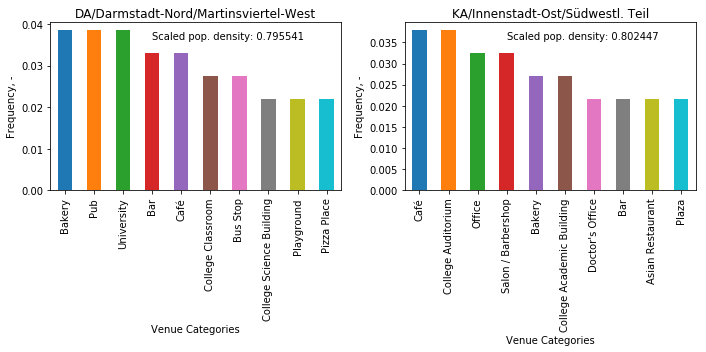

In [136]:
name_a='Martinsviertel-West'
name_b='Südwestl. Teil'

printTwoNeighborhoodsWithBars(name_a, name_b,venues_grouped,'most_common_ngh')

In [137]:
file_data=open("most_common_ngh.pdf", 'rb')
project.save_data(data=file_data.read(),file_name='most_common_ngh.pdf',overwrite=True)
file_data.close()

#### Which neighborhood in Karlsruhe is similar to the neighborhood I am currently living in in Darmstadt (Pallaswiesenviertel)? 

Following the Dendrogram, it seems to be Karlsruhe Südweststadt - Beiertheimer Feld.

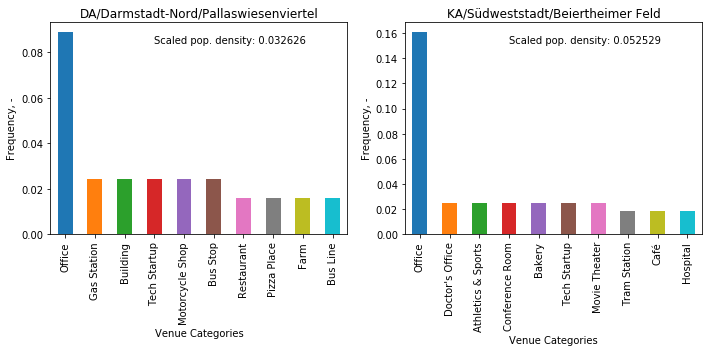

In [138]:
name_a='Pallaswiesenviertel'
name_b='Beiertheimer Feld'

printTwoNeighborhoodsWithBars(name_a, name_b,venues_grouped,'similar_to_pallas')

In [139]:
file_data=open("similar_to_pallas.pdf", 'rb')
project.save_data(data=file_data.read(),file_name='similar_to_pallas.pdf',overwrite=True)
file_data.close()